In [90]:
import numpy as np
import pandas as pd
import xarray as xr

import jax
import optax

import matplotlib.pyplot as plt

from pywbm.water_balance_jax import *

### Read climate data

In [2]:
# Read sample climate data: pre-processed GMFD observations
# containing daily precipitation and temperature from 1948-2008.
ds = xr.open_dataset("../data/conus.nc")

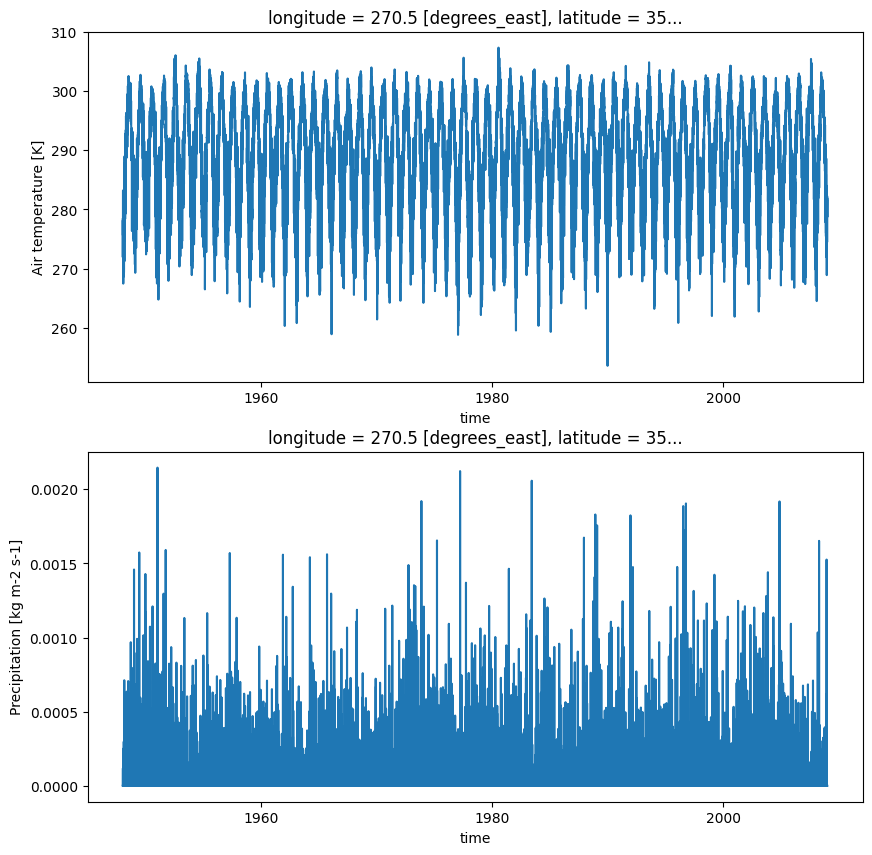

In [3]:
# Take a look at timeseries for random point
lat, lon = 35, 270
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ds.sel(latitude=lat, longitude=lon, method="nearest")["tas"].plot(ax=axs[0])
ds.sel(latitude=lat, longitude=lon, method="nearest")["prcp"].plot(ax=axs[1])
plt.show()

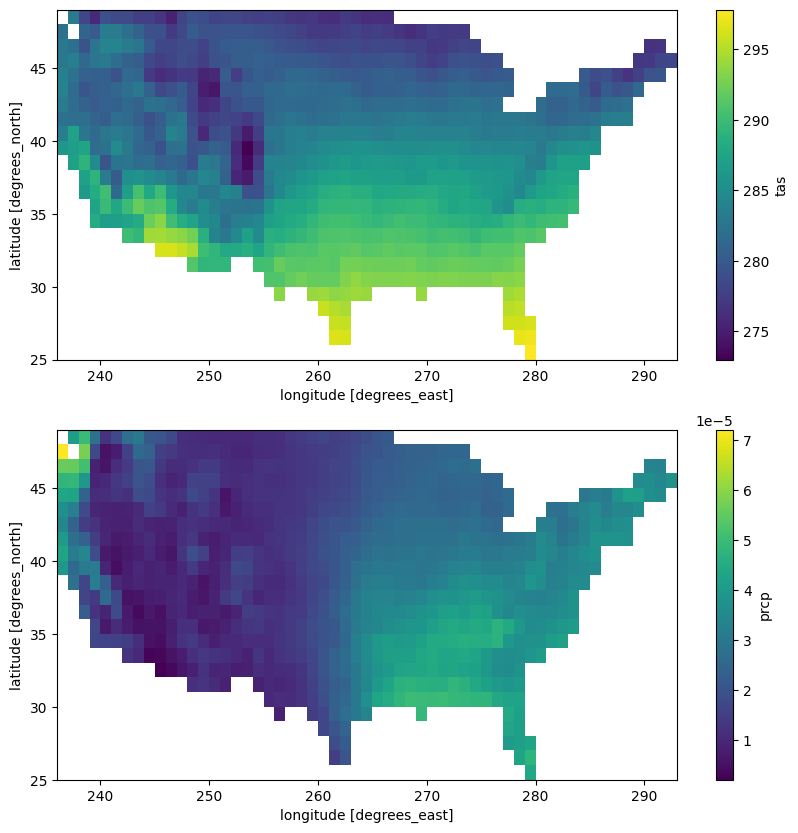

In [4]:
# Take a look at the long term averages
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ds["tas"].mean(dim="time").plot(ax=axs[0])
ds["prcp"].mean(dim="time").plot(ax=axs[1])
plt.show()

### Simple simulation: constant soil parameters

The strategy for running pyWBM across space is to leverage JAX's native vectorization using the `vmap` function (https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html). Since pyWBM contains no lateral flow of water, we can simulate each pixel independently. `vmap` allows us to run the model across space in a vectorized manner, which is much faster than looping over each pixel. In order to do so, we need to take the 3-dimensional forcing data (lat/lon/time) and collapse (or stack) the two spatial dimensions into one, which provides `vmap` with a single axis to vectorize over. Similarly, for the other inputs to the model--parameters or initial conditions--we need to ensure that their spatial dimensions are similarly collapsed into a single axis. Then, after running the model, we can reshape or unstack the output back into the original dimensions.

Note that we could also use `pmap` (https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html) here in order to parallelize this operation. This could be explored in future.

In [63]:
# Stack using xarray's stack method
ds_stacked = ds.stack(points=["latitude", "longitude"])

tas_stacked = ds_stacked["tas"].to_numpy().T
tas_stacked = tas_stacked - 273.15  # K -> C

prcp_stacked = ds_stacked["prcp"].to_numpy().T
prcp_stacked = prcp_stacked * 86400  # kgm/s -> mm/day

# Dimension of the simulation
nx = ds["longitude"].size
ny = ds["latitude"].size
nxy = nx * ny
nt = ds["time"].size

In [64]:
## Read LAI
# For this simple example, we will use a climatology of LAI which is constant over space.
# If we have LAI as a .nc file, we would stack it in the same way as we did for tas and prcp.
lai = np.loadtxt("../data/mclean_county_daily_lai_climatology.csv")

In [65]:
## Define some parameters for a test simulation
# Here we are going to use spatially constant values for the parameters. So, we define them
# here as floats, and then tile them to the correct spatial axis length `nxy`.
Ts = -1.0
Tm = 1.0
awCap = 300.0
wiltingp = 120.0
rootDepth = 1.0
alpha = 5.5
betaHBV = 3.4

# Construct input dicts
theta = {
    "awCap": np.tile(awCap, nxy),
    "wiltingp": np.tile(wiltingp, nxy),
    "alpha": np.tile(alpha, nxy),
    "betaHBV": np.tile(betaHBV, nxy),
}

constants = {
    "Ts": np.tile(Ts, nxy),
    "Tm": np.tile(Tm, nxy),
    "rootDepth": np.tile(rootDepth, nxy),
    "phi": ds_stacked[
        "latitude"
    ].to_numpy(),  # note this one is different because there is some spatial variation
}

params = {**theta, **constants}

In [66]:
## Forcing
# PET scaling timeseries
Kmin = 0.3
Kmax = 1.2
c_lai = 0.7

Kpet = construct_Kpet_gen(Kmin, Kmax, c_lai, lai)

# The forcing dict contains tas and prcp, which we have already handled, as well as Kpet and LAI, which are defined via
# their climatologies (ie only 365 days). pyWBM expects these inputs to have a time dimension of 365, so here we only need
# to tile them to the correct spatial dimension.
forcing = {
    "tas": tas_stacked,
    "prcp": prcp_stacked,
    "Kpet": np.tile(Kpet, nxy).reshape(nxy, 365),
    "lai": np.tile(lai, nxy).reshape(nxy, 365),
}

In [67]:
# Initial conditions are again constant
init = {
    "Ws_init": np.tile(250.0, nxy),
    "Wi_init": np.tile(0.0, nxy),
    "Sp_init": np.tile(0.0, nxy),
}

In [68]:
# Make the vmap function
run_water_balance_vmap = jax.jit(jax.vmap(run_water_balance, in_axes=(0, 0, 0), out_axes=0))

In [69]:
%%time
# 10 years
out = run_water_balance_vmap(forcing, init, params)

CPU times: user 496 ms, sys: 27.1 ms, total: 524 ms
Wall time: 177 ms


In [70]:
# Add outputs to the stacked array and then unstack
ds_stacked["soilMoist"] = (("points", "time"), out)
ds_out = ds_stacked.unstack("points")

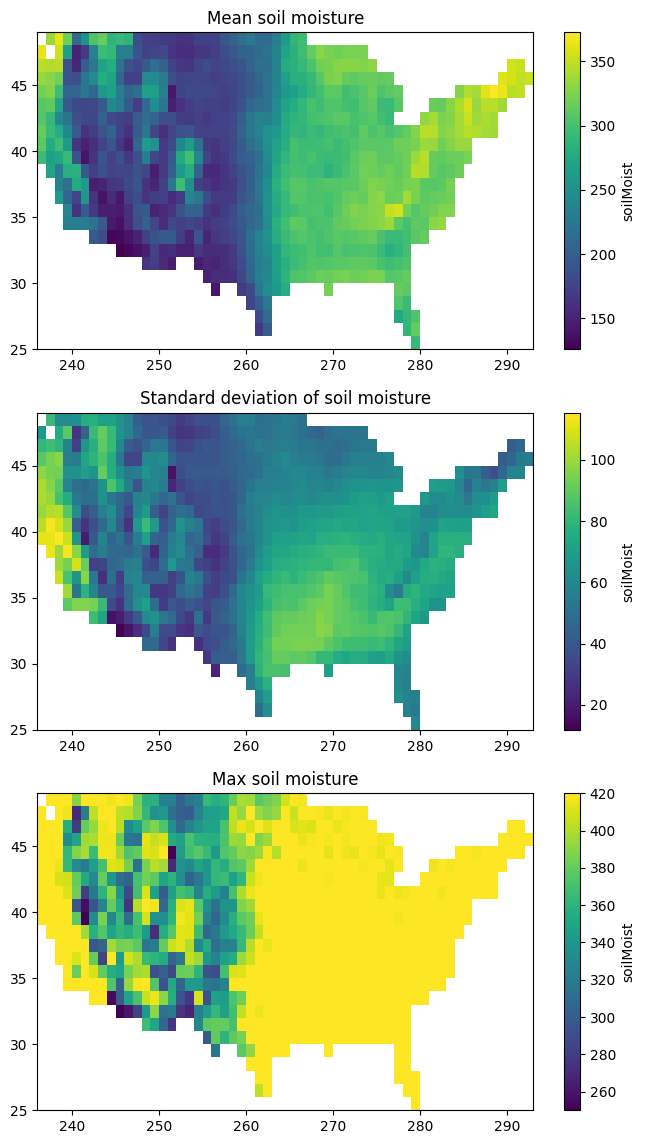

In [71]:
# Plot some summary statistics
fig, axs = plt.subplots(3, 1, figsize=(8, 14))

ds_out["soilMoist"].mean(dim="time", skipna=False).plot(ax=axs[0])
axs[0].set_title("Mean soil moisture")

ds_out["soilMoist"].std(dim="time", skipna=False).plot(ax=axs[1])
axs[1].set_title("Standard deviation of soil moisture")

ds_out["soilMoist"].max(dim="time", skipna=False).plot(ax=axs[2])
axs[2].set_title("Max soil moisture")

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.show()

You can see here that since the only spatial variation comes from the climate drivers, the soil moisture patterns are closely related. In reality, there is more variation due to soil properties, topography, vegetation, hydrologic parameters, etc, which will be explored soon.

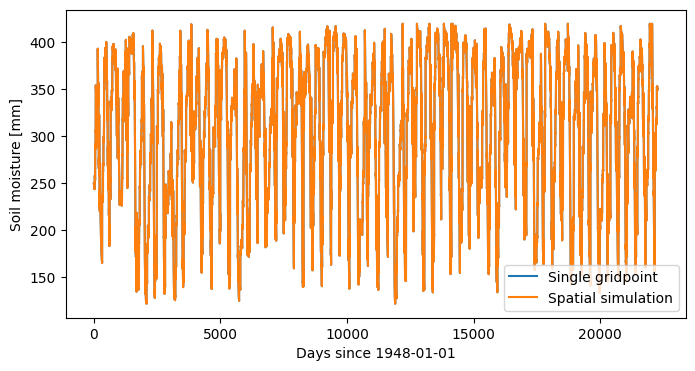

In [72]:
# Let's verify that the spatial simulation gives the same result as the point simulation.

# Choose a test gridpoint
lat_isel = 12
lon_isel = 30


# Set up single gridpoint simulation with same parameters
params = {
    "awCap": awCap,
    "wiltingp": wiltingp,
    "alpha": alpha,
    "betaHBV": betaHBV,
    "Ts": Ts,
    "Tm": Tm,
    "rootDepth": rootDepth,
    "phi": ds.isel(latitude=lat_isel, longitude=lon_isel)["latitude"].to_numpy(),
}

forcing = {
    "tas": ds.isel(latitude=lat_isel, longitude=lon_isel)["tas"].to_numpy() - 273.15,
    "prcp": ds.isel(latitude=lat_isel, longitude=lon_isel)["prcp"].to_numpy() * 86400,
    "Kpet": Kpet,
    "lai": lai,
}

init = {
    "Ws_init": 250.0,
    "Wi_init": 0.0,
    "Sp_init": 0.0,
}

# Simulate soil moisture: single gridpoint
soilM_test = run_water_balance(
    forcing=forcing,
    init=init,
    params=params,
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(soilM_test, label="Single gridpoint")
ax.plot(
    ds_out["soilMoist"].isel(latitude=lat_isel, longitude=lon_isel), label="Spatial simulation"
)
ax.set_ylabel("Soil moisture [mm]")
ax.set_xlabel("Days since 1948-01-01")
ax.legend()
plt.show()

### Spatial calibration

In [301]:
# Read sample climate data: pre-processed GMFD observations
# containing daily precipitation and temperature from 1948-2008.
ds = xr.open_dataset("../data/conus.nc")

In [302]:
# Stack using xarray's stack method
ds_stacked = ds.stack(points=["latitude", "longitude"])
# For calibration we need to drop the NaNs
ds_stacked = ds_stacked.dropna(dim="points")

tas_stacked = ds_stacked["tas"].to_numpy().T
tas_stacked = tas_stacked - 273.15  # K -> C

prcp_stacked = ds_stacked["prcp"].to_numpy().T
prcp_stacked = prcp_stacked * 86400  # kgm/s -> mm/day

# Dimension of the simulation
nx = ds["longitude"].size
ny = ds["latitude"].size
nxy = ds_stacked["points"].size
nt = ds["time"].size

In [303]:
## Read LAI
# For this simple example, we will use a climatology of LAI which is constant over space.
# If we have LAI as a .nc file, we would stack it in the same way as we did for tas and prcp.
lai = np.loadtxt("../data/mclean_county_daily_lai_climatology.csv")

In [304]:
# Let's assume that the parameters vary as a function of latitude only
ds_params = xr.ones_like(ds_stacked.isel(time=0)).drop_vars(["time", "tas", "prcp"])

theta_true = {
    "awCap_beta0": 200.0,
    "awCap_beta1": 3.0,
    "wiltingp_beta0": 100.0,
    "wiltingp_beta1": 2.0,
    "alpha_beta0": 1.2,
    "alpha_beta1": 0.02,
    "betaHBV_beta0": 0.02,
    "betaHBV_beta1": 0.1,
}

ds_params["awCap"] = theta_true["awCap_beta0"] + (
    ds_stacked["latitude"] * theta_true["awCap_beta1"]
)
ds_params["wiltingp"] = theta_true["wiltingp_beta0"] + (
    ds_stacked["latitude"] * theta_true["wiltingp_beta1"]
)
ds_params["alpha"] = theta_true["alpha_beta0"] + (
    ds_stacked["latitude"] * theta_true["alpha_beta1"]
)
ds_params["betaHBV"] = theta_true["betaHBV_beta0"] + (
    ds_stacked["latitude"] * theta_true["betaHBV_beta1"]
)

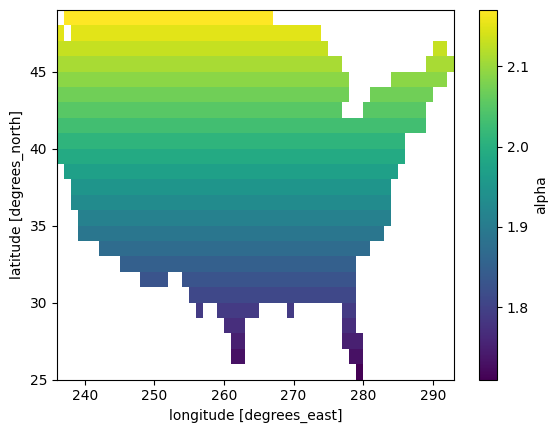

In [305]:
# What does this look like?
ds_params.unstack("points")["alpha"].plot()

In [306]:
## Define some parameters for a test simulation
# Here we are going to use spatially constant values for the parameters. So, we define them
# here as floats, and then tile them to the correct spatial axis length `nxy`.
Ts = -1.0
Tm = 1.0
rootDepth = 1.0

# Construct input dicts
theta_true_mapped = {
    "awCap": ds_params["awCap"].to_numpy(),
    "wiltingp": ds_params["wiltingp"].to_numpy(),
    "alpha": ds_params["alpha"].to_numpy(),
    "betaHBV": ds_params["betaHBV"].to_numpy(),
}

constants = {
    "Ts": np.tile(Ts, nxy),
    "Tm": np.tile(Tm, nxy),
    "rootDepth": np.tile(rootDepth, nxy),
    "phi": ds_stacked[
        "latitude"
    ].to_numpy(),  # note this one is different because there is some spatial variation
}

params = {**theta_true_mapped, **constants}

In [307]:
## Forcing
# PET scaling timeseries
Kmin = 0.3
Kmax = 1.2
c_lai = 0.7

Kpet = construct_Kpet_gen(Kmin, Kmax, c_lai, lai)

# The forcing dict contains tas and prcp, which we have already handled, as well as Kpet and LAI, which are defined via
# their climatologies (ie only 365 days). pyWBM expects these inputs to have a time dimension of 365, so here we only need
# to tile them to the correct spatial dimension.
forcing = {
    "tas": tas_stacked,
    "prcp": prcp_stacked,
    "Kpet": np.tile(Kpet, nxy).reshape(nxy, 365),
    "lai": np.tile(lai, nxy).reshape(nxy, 365),
}

In [308]:
# Initial conditions are again constant
init = {
    "Ws_init": np.tile(250.0, nxy),
    "Wi_init": np.tile(0.0, nxy),
    "Sp_init": np.tile(0.0, nxy),
}

In [309]:
# Make the vmap function
run_water_balance_vmap = jax.jit(jax.vmap(run_water_balance, in_axes=(0, 0, 0), out_axes=0))

In [310]:
%%time
# 10 years
soilM_true = run_water_balance_vmap(forcing, init, params)

CPU times: user 2.26 s, sys: 827 ms, total: 3.09 s
Wall time: 1.68 s


In [311]:
# Add outputs to the stacked array and then unstack
ds_stacked["soilMoist_true"] = (("points", "time"), soilM_true)
ds_out = ds_stacked.unstack("points")

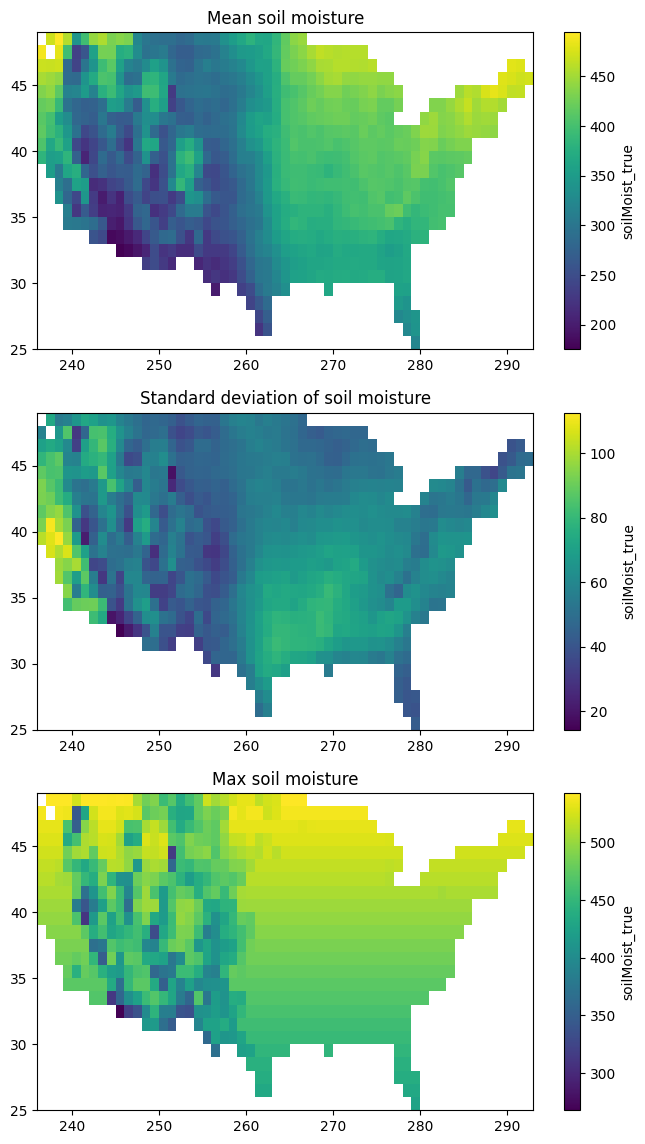

In [312]:
# Plot some summary statistics
fig, axs = plt.subplots(3, 1, figsize=(8, 14))

ds_out["soilMoist_true"].mean(dim="time", skipna=False).plot(ax=axs[0])
axs[0].set_title("Mean soil moisture")

ds_out["soilMoist_true"].std(dim="time", skipna=False).plot(ax=axs[1])
axs[1].set_title("Standard deviation of soil moisture")

ds_out["soilMoist_true"].max(dim="time", skipna=False).plot(ax=axs[2])
axs[2].set_title("Max soil moisture")

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.show()

In [313]:
# Assume we want to calibrate the crop coefficient timeseries and initialalization values, as well as
# some soil parameters. We can do this by defining a new loss function that depends on all of these
# uncertain inputs.
@jax.jit
def pywbm_spatial_wrapper(theta, constants, forcing, init):
    # We continue to use `theta` nomenclature for uncertain parameters.
    # Extract everything here for clarity. These represent all the uncertain
    # inputs that we want to calibrate.
    awCap_beta0 = theta["awCap_beta0"]
    awCap_beta1 = theta["awCap_beta1"]
    wiltingp_beta0 = theta["wiltingp_beta0"]
    wiltingp_beta1 = theta["wiltingp_beta1"]
    alpha_beta0 = theta["alpha_beta0"]
    alpha_beta1 = theta["alpha_beta1"]
    betaHBV_beta0 = theta["betaHBV_beta0"]
    betaHBV_beta1 = theta["betaHBV_beta1"]

    # Construct the maps
    awCap = awCap_beta0 + awCap_beta1 * constants["phi"]
    wiltingp = wiltingp_beta0 + wiltingp_beta1 * constants["phi"]
    alpha = alpha_beta0 + alpha_beta1 * constants["phi"]
    betaHBV = betaHBV_beta0 + betaHBV_beta1 * constants["phi"]

    # Construct input dicts
    theta = {
        "awCap": awCap,
        "wiltingp": wiltingp,
        "alpha": alpha,
        "betaHBV": betaHBV,
    }

    params = {**theta, **constants}

    # Run it
    soilM = run_water_balance_vmap(forcing, init, params)

    return soilM


# Define a loss metric: RMSE
def _rmse(prediction, ys):
    return jnp.sqrt(jnp.nanmean((prediction - ys) ** 2))


# Finally, we can define a new (but similar) loss and update function. This is similar to before
# but accounts for the new structure of the wrapper function.
def loss(theta, constants, forcing, init, ys):
    prediction = pywbm_spatial_wrapper(theta, constants, forcing, init)
    return _rmse(prediction, ys)


@jax.jit
def update(theta, constants, forcing, init, ys, opt_state):
    # Gradient calculation
    # Note jax.grad differentiates with respect to the first argument by default, but
    # this can be changed with the `argnums` argument.
    loss_grad = jax.grad(loss)

    # Update
    gradients = loss_grad(theta, constants, forcing, init, ys)
    updates, opt_state = opt_fn(gradients, opt_state)
    theta = optax.apply_updates(theta, updates)
    return theta


# Choose an optimizer
def initialize_optimizer(opt_name, learning_rate, theta):
    if opt_name == "adam":
        adam = optax.adam(learning_rate=learning_rate)
        opt_fn = adam.update
        opt_state = adam.init(theta)
    elif opt_name == "sgd":
        opt_state = None

        def sgd(gradients, state):
            return {k: v - learning_rate * gradients for k, v in theta.items()}, state

        opt_fn = sgd

    return opt_fn, opt_state

In [314]:
# Initial guess for params: what is the loss?
theta_init = {
    "awCap_beta0": 100.0,
    "awCap_beta1": 0.0,
    "wiltingp_beta0": 50.0,
    "wiltingp_beta1": 0.0,
    "alpha_beta0": 1.0,
    "alpha_beta1": 1.0,
    "betaHBV_beta0": 1.0,
    "betaHBV_beta1": 1.0,
}

loss(theta_init, constants, forcing, init, soilM_true)

Array(258.11243, dtype=float32)

In [315]:
# Check that true theta gives zero loss
loss(theta_true, constants, forcing, init, soilM_true)

Array(6.177441e-06, dtype=float32)

In [316]:
## Run the calibration: batch gradient descent
n_epochs = 30
batch_loss = np.zeros(n_epochs)
batch_loss[0] = loss(theta_init, constants, forcing, init, soilM_true)

# Starting values
theta = theta_init.copy()

# Optimizer initialization
opt_fn, opt_state = initialize_optimizer("adam", 0.02, theta)

# Training loop
for epoch in range(1, n_epochs):
    theta = update(
        theta,
        constants,
        forcing,
        init,
        soilM_true,
        opt_state,
    )

    # Store loss
    batch_loss[epoch] = loss(theta, constants, forcing, init, soilM_true)

In [317]:
# How close did we get?
data = {
    "True": [theta_true[param] for param in theta],
    "Estimated": [theta[param] for param in theta],
}
df = pd.DataFrame(data, index=theta.keys())
df["Pct diff"] = (df["Estimated"] - df["True"]) / df["True"] * 100
print(df)

                  True   Estimated    Pct diff
alpha_beta0       1.20    0.420004   -64.99967
alpha_beta1       0.02    0.420004     2000.02
awCap_beta0     200.00    100.5799   -49.71005
awCap_beta1       3.00  0.57999605    -80.6668
betaHBV_beta0     0.02   1.5799938   7799.9697
betaHBV_beta1     0.10    1.579996    1479.996
wiltingp_beta0  100.00   50.580013  -49.419987
wiltingp_beta1    2.00  0.57999605    -71.0002


In [318]:
## Run the calibration: stochastic gradient descent
n_epochs = 30

sgd_loss = np.zeros(n_epochs)
sgd_loss[0] = loss(theta_init, constants, forcing, init, soilM_true)

# Starting values
theta = theta_init.copy()

# Optimizer initialization
opt_fn, opt_state = initialize_optimizer("adam", 0.02, theta)

# Training loop
for epoch in range(1, n_epochs):
    # Shuffle indices
    shuffled_inds = np.random.permutation(nxy)

    # Iterate through mini-batches
    for inds in shuffled_inds:
        theta = update(
            theta,
            {key: value[[inds]] for key, value in constants.items()},
            {key: value[[inds]] for key, value in forcing.items()},
            {key: value[[inds]] for key, value in init.items()},
            soilM_true[inds],
            opt_state,
        )

    # Store loss
    sgd_loss[epoch] = loss(theta, constants, forcing, init, soilM_true)

In [319]:
# How close did we get?
data = {
    "True": [theta_true[param] for param in theta],
    "Estimated": [theta[param] for param in theta],
}
df = pd.DataFrame(data, index=theta.keys())
df["Pct diff"] = (df["Estimated"] - df["True"]) / df["True"] * 100
print(df)

                  True    Estimated    Pct diff
alpha_beta0       1.20   0.06000692   -94.99942
alpha_beta1       0.02  0.060006198   200.03099
awCap_beta0     200.00    105.57906   -47.21047
awCap_beta1       3.00    5.5799828    85.99942
betaHBV_beta0     0.02   0.37274075   1763.7037
betaHBV_beta1     0.10  0.100754805   0.7548034
wiltingp_beta0  100.00    53.220078  -46.779922
wiltingp_beta1    2.00    3.2199848   60.999237


In [320]:
sgd_loss

array([258.11242676,  19.14004707,  14.60366535,  18.6895237 ,
        15.38079834,  11.71108627,  22.17749977,  17.40824509,
        20.30423355,  53.04925156,  52.65381622,  18.51516151,
        15.51197052,  16.41184425,  14.0218029 ,  15.17075729,
        16.57487106,  13.65397167,  23.29137611,  12.54291916,
        26.63898659,  13.18855381,  17.00525665,  12.87652683,
        22.42368698,  19.71358871,  15.79017448,  12.73673153,
        16.98210907,  13.18228531])

In [321]:
## Run the calibration: mini-batch gradient descent
n_epochs = 30
batch_size = 8
n_minibatches = int(np.ceil(nxy / batch_size))

minibatch_loss = np.zeros(n_epochs)
minibatch_loss[0] = loss(theta_init, constants, forcing, init, soilM_true)

# Starting values
theta = theta_init.copy()

# Optimizer initialization
opt_fn, opt_state = initialize_optimizer("adam", 0.02, theta)

# Training loop
for epoch in range(1, n_epochs):
    # Shuffle indices
    shuffled_inds = np.random.permutation(nxy)

    # Generate a mini-batch
    minibatch_inds = [
        shuffled_inds[(i * batch_size) : ((i + 1) * batch_size)] for i in range(n_minibatches)
    ]

    # Iterate through mini-batches
    for inds in minibatch_inds:
        theta = update(
            theta,
            {key: value[inds] for key, value in constants.items()},
            {key: value[inds] for key, value in forcing.items()},
            {key: value[inds] for key, value in init.items()},
            soilM_true[inds],
            opt_state,
        )

    # Store loss
    minibatch_loss[epoch] = loss(theta, constants, forcing, init, soilM_true)

In [322]:
# How close did we get?
data = {
    "True": [theta_true[param] for param in theta],
    "Estimated": [theta[param] for param in theta],
}
df = pd.DataFrame(data, index=theta.keys())
df["Pct diff"] = (df["Estimated"] - df["True"]) / df["True"] * 100
print(df)

                  True    Estimated    Pct diff
alpha_beta0       1.20  -0.41999003  -134.99916
alpha_beta1       0.02   0.06000645   200.03226
awCap_beta0     200.00    109.33843  -45.330784
awCap_beta1       3.00     5.179983     72.6661
betaHBV_beta0     0.02    3.2203794   16001.896
betaHBV_beta1     0.10  0.019991651  -80.008354
wiltingp_beta0  100.00     56.06014   -43.93986
wiltingp_beta1    2.00    3.3799844    68.99922


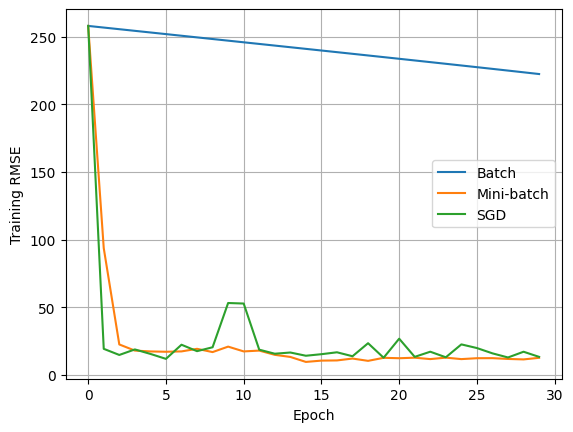

In [323]:
# Show the learning curves
fig, ax = plt.subplots()
ax.plot(batch_loss, label="Batch")
ax.plot(minibatch_loss, label="Mini-batch")
ax.plot(sgd_loss, label="SGD")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training RMSE")
ax.legend()
ax.grid()
plt.show()

In [324]:
# Show best fit against obs
soilM_best = pywbm_spatial_wrapper(theta, constants, forcing, init)
soilM_init = pywbm_spatial_wrapper(theta_init, constants, forcing, init)

In [325]:
# Add outputs to the stacked array and then unstack
ds_stacked["soilMoist_best"] = (("points", "time"), soilM_best)
ds_stacked["soilMoist_init"] = (("points", "time"), soilM_init)
ds_out = ds_stacked.unstack("points")

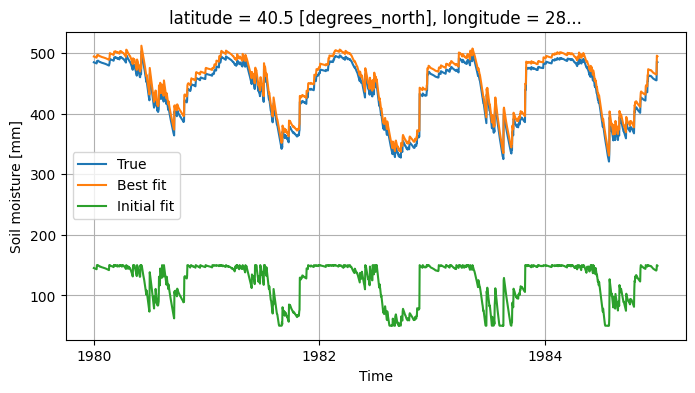

In [326]:
# Plot
lat, lon = 40, 280

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ds_out.sel(latitude=lat, longitude=lon, method="nearest").sel(
    time=slice("1980-01-01", "1985-01-01")
)["soilMoist_true"].plot(label="True")

ds_out.sel(latitude=lat, longitude=lon, method="nearest").sel(
    time=slice("1980-01-01", "1985-01-01")
)["soilMoist_best"].plot(label="Best fit")

ds_out.sel(latitude=lat, longitude=lon, method="nearest").sel(
    time=slice("1980-01-01", "1985-01-01")
)["soilMoist_init"].plot(label="Initial fit")

ax.set_ylabel("Soil moisture [mm]")
ax.set_xlabel("Time")
ax.legend()
ax.grid()

plt.show()